# NYC Water Consumption EDA Notebook

Goal is to visualize NYC population water consumption for a hypothetical local stakeholder interested in water conservation and educating the public.



Code for reading in a json file from the online [city of New York API on Water Consumption](https://https://data.cityofnewyork.us/Environment/Water-Consumption-in-the-City-of-New-York/ia2d-e54m)

- Learn how to create a schema
- Learn how to rename columns
- Learn how to check for missing values
- Learn how to get summary stats (mean, median, etc.)
- Learn how to use built-in functions
- Learn how to make plots


## Install Spark

- Google colab recently made some changes which breaks the Spark installation.
- Please use the code below where we install from the pyspark package instead

In [1]:
!pip install pyspark==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317123 sha256=206a1166f737751c08bfac3c06c385f29e67b6a17dcf32163b932dbcb1d848b3
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

## Downloading New York Weather Data

In [3]:
#Doing the wget command to download a file from nygov api

!wget https://data.cityofnewyork.us/resource/ia2d-e54m.json

--2023-12-20 15:33:52--  https://data.cityofnewyork.us/resource/ia2d-e54m.json
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘ia2d-e54m.json’

ia2d-e54m.json          [ <=>                ]   6.46K  --.-KB/s    in 0s      

2023-12-20 15:33:52 (815 MB/s) - ‘ia2d-e54m.json’ saved [6615]



**File above saved as ia2d-e54m.json so want to rename it below for ease of use**

In [4]:
#Listing out the file for sanity check -- if file is not there rerun the spark session
!ls -l

total 12
-rw-r--r-- 1 root root 6615 May 10  2023 ia2d-e54m.json
drwxr-xr-x 1 root root 4096 Dec 18 14:23 sample_data


In [5]:
#Renaming the file to water.json and checking to see if it saved the changes

!mv ia2d-e54m.json water.json
!ls -l

total 12
drwxr-xr-x 1 root root 4096 Dec 18 14:23 sample_data
-rw-r--r-- 1 root root 6615 May 10  2023 water.json


In [6]:
#Read in multiple lines of a json file

df = spark.read.option("multiline","true") \
      .json("water.json")

#Check the first five rows

df.show(5)


+------------------------+---------------------------------------+-------------------------------------+----+
|new_york_city_population|nyc_consumption_million_gallons_per_day|per_capita_gallons_per_person_per_day|year|
+------------------------+---------------------------------------+-------------------------------------+----+
|                 7102100|                                   1512|                                  213|1979|
|                 7071639|                                   1506|                                  213|1980|
|                 7089241|                                   1309|                                  185|1981|
|                 7109105|                                   1382|                                  194|1982|
|                 7181224|                                   1424|                                  198|1983|
+------------------------+---------------------------------------+-------------------------------------+----+
only showi

### Change the schema with the appropiate data types

In [7]:
#Look at the schema to get datatypes similar to .info() in pandas

df.printSchema()

root
 |-- new_york_city_population: string (nullable = true)
 |-- nyc_consumption_million_gallons_per_day: string (nullable = true)
 |-- per_capita_gallons_per_person_per_day: string (nullable = true)
 |-- year: string (nullable = true)



In [8]:
from pyspark.sql.types import IntegerType, DateType

In [9]:
#Change data types

df2 = df.withColumn("new_york_city_population", df.new_york_city_population.cast(IntegerType())) \
.withColumn("nyc_consumption_million_gallons_per_day", df.nyc_consumption_million_gallons_per_day.cast(IntegerType())) \
.withColumn("per_capita_gallons_per_person_per_day", df.per_capita_gallons_per_person_per_day.cast(IntegerType())) \
.withColumn("year", df.year.cast(DateType()))

In [10]:
#Sanity Check

df2.printSchema()

root
 |-- new_york_city_population: integer (nullable = true)
 |-- nyc_consumption_million_gallons_per_day: integer (nullable = true)
 |-- per_capita_gallons_per_person_per_day: integer (nullable = true)
 |-- year: date (nullable = true)



In [11]:
#Rename columns

df2 = df2.withColumnRenamed("new_york_city_population", "Population") \
       .withColumnRenamed("nyc_consumption_million_gallons_per_day", "Consumption_Million_Gallons_PerDay") \
       .withColumnRenamed("per_capita_gallons_per_person_per_day", "PerCapita_Gallons_PerDay") \
       .withColumnRenamed("year", "Year")

In [12]:
df2.printSchema()

root
 |-- Population: integer (nullable = true)
 |-- Consumption_Million_Gallons_PerDay: integer (nullable = true)
 |-- PerCapita_Gallons_PerDay: integer (nullable = true)
 |-- Year: date (nullable = true)



## Exploratory Data Analysis

- Check for missing values
- Summary Statistics (mean, median, stddev)
- Visuals (histograms for distributions of numeric variables and line chart to see trends across time)

In [13]:
#See if there is any missing values in numeric columns

from pyspark.sql.functions import col, isnan, when, count
num_cols = ["Population", "Consumption_Million_Gallons_PerDay", "PerCapita_Gallons_PerDay"]
df2.select([count(when(isnan(c), c)).alias(c) for c in num_cols]).show()

+----------+----------------------------------+------------------------+
|Population|Consumption_Million_Gallons_PerDay|PerCapita_Gallons_PerDay|
+----------+----------------------------------+------------------------+
|         0|                                 0|                       0|
+----------+----------------------------------+------------------------+



### Summary Statistics (EDA)

In [14]:
from pyspark.sql.functions import mean, median, stddev, min, max, datediff, lit, col, struct, desc

In [15]:
df2.select(mean(col("Consumption_Million_Gallons_PerDay")), stddev(col("Consumption_Million_Gallons_PerDay"))).show()

+---------------------------------------+-----------------------------------------------+
|avg(Consumption_Million_Gallons_PerDay)|stddev_samp(Consumption_Million_Gallons_PerDay)|
+---------------------------------------+-----------------------------------------------+
|                     1206.3863636363637|                              181.9275623682681|
+---------------------------------------+-----------------------------------------------+



In [16]:
df2.select(min(col('Year')), max(col('Year')),datediff(max(col('Year')), min(col('Year')))).show()

+----------+----------+------------------------------+
| min(Year)| max(Year)|datediff(max(Year), min(Year))|
+----------+----------+------------------------------+
|1979-01-01|2022-01-01|                         15706|
+----------+----------+------------------------------+



In [17]:
#showing a group by -- but each year only appears once in the dataset

sorted(df2.groupBy('Year').agg({'Population':'sum'}).collect())

[Row(Year=datetime.date(1979, 1, 1), sum(Population)=7102100),
 Row(Year=datetime.date(1980, 1, 1), sum(Population)=7071639),
 Row(Year=datetime.date(1981, 1, 1), sum(Population)=7089241),
 Row(Year=datetime.date(1982, 1, 1), sum(Population)=7109105),
 Row(Year=datetime.date(1983, 1, 1), sum(Population)=7181224),
 Row(Year=datetime.date(1984, 1, 1), sum(Population)=7234514),
 Row(Year=datetime.date(1985, 1, 1), sum(Population)=7274054),
 Row(Year=datetime.date(1986, 1, 1), sum(Population)=7319246),
 Row(Year=datetime.date(1987, 1, 1), sum(Population)=7342476),
 Row(Year=datetime.date(1988, 1, 1), sum(Population)=7353719),
 Row(Year=datetime.date(1989, 1, 1), sum(Population)=7344175),
 Row(Year=datetime.date(1990, 1, 1), sum(Population)=7335650),
 Row(Year=datetime.date(1991, 1, 1), sum(Population)=7374501),
 Row(Year=datetime.date(1992, 1, 1), sum(Population)=7428944),
 Row(Year=datetime.date(1993, 1, 1), sum(Population)=7506166),
 Row(Year=datetime.date(1994, 1, 1), sum(Population)=75

### Visuals

In [18]:
#change file into a dataframe for ease

df3 = df2.toPandas()

In [19]:
type(df3)

pandas.core.frame.DataFrame

In [20]:
import matplotlib.pyplot as plt

array([[<Axes: title={'center': 'Consumption_Million_Gallons_PerDay'}>]],
      dtype=object)

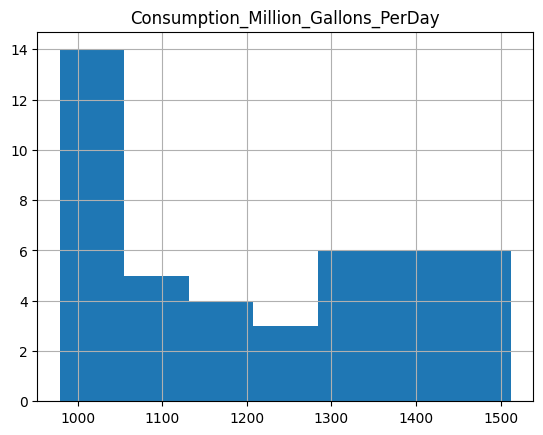

In [21]:
df3.hist('Consumption_Million_Gallons_PerDay', bins=7)

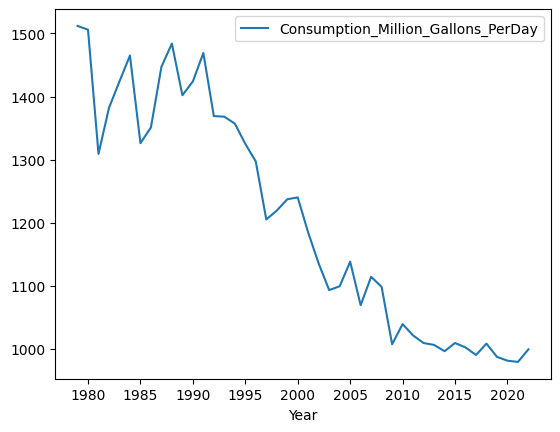

In [22]:
df3.plot(kind = 'line', x = "Year", y="Consumption_Million_Gallons_PerDay")
plt.show()

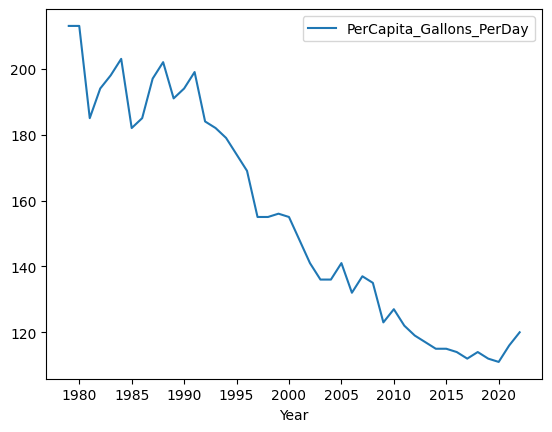

In [23]:
#Notice y-axis changes but trend is the same
df3.plot(kind = 'line', x = "Year", y="PerCapita_Gallons_PerDay")
plt.show()